<a href="https://colab.research.google.com/github/CyanString/miniProject/blob/main/Frog_and_tail_yyz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Frogtail Project

## Environment Setting



In [ ]:
!pip -q install "numpy==1.24.4" "scanpy==1.9.8" "anndata==0.10.7" "leidenalg==0.10.2" "pynndescent" "matplotlib>=3.7" "pandas>=2.0"
!pip install -q scikit-misc
!pip install leidenalg
!pip install louvain==0.8.1
import os, sys, re, warnings
warnings.filterwarnings("ignore")


from google.colab import drive
drive.mount('/content/drive')


OUTDIR = "/content/drive/MyDrive/frogtail_project/outputs"
os.makedirs(OUTDIR, exist_ok=True)


  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data processing

In [ ]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load the data
sc.settings.set_figure_params(dpi=110, facecolor="white")
sc.settings.figdir = OUTDIR

adata_path = "/content/drive/MyDrive/frogtail_project/data/cleaned_processed_frogtail.h5ad"
adata = ad.read_h5ad(adata_path)

print(adata)
print("adata.X format:", type(adata.X))
print("obs columns:", list(adata.obs.columns)[:20])



AnnData object with n_obs × n_vars = 13199 × 31535
    obs: 'barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch'
adata.X format: <class 'scipy.sparse._csr.csr_matrix'>
obs columns: ['barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch']


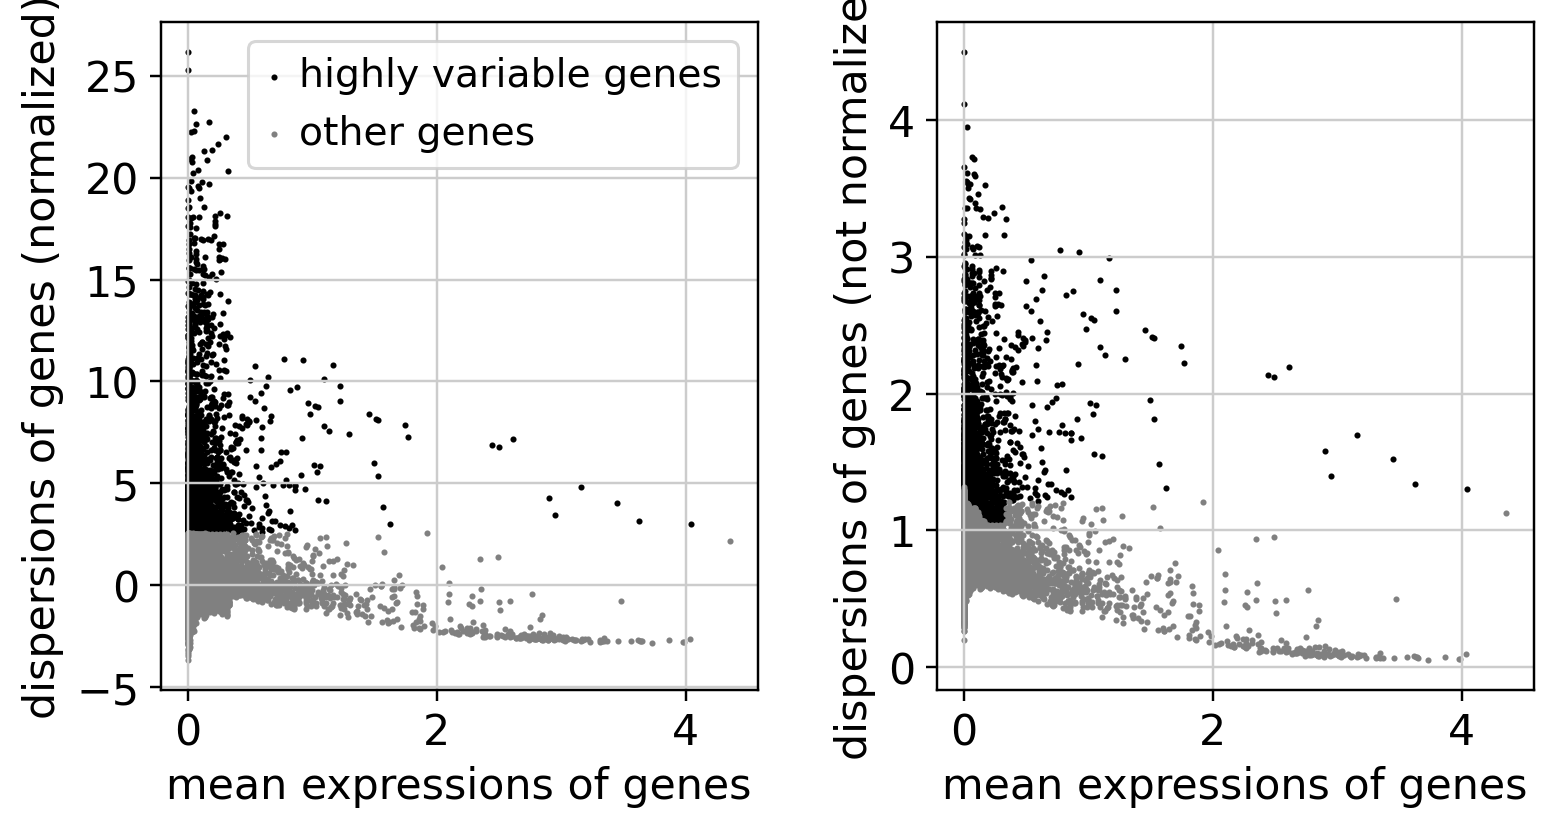

In [ ]:

# data processing

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.highly_variable_genes(adata, n_top_genes=2300)



sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2300,
    flavor="cell_ranger",
    subset=False
)


sc.pl.highly_variable_genes(adata)



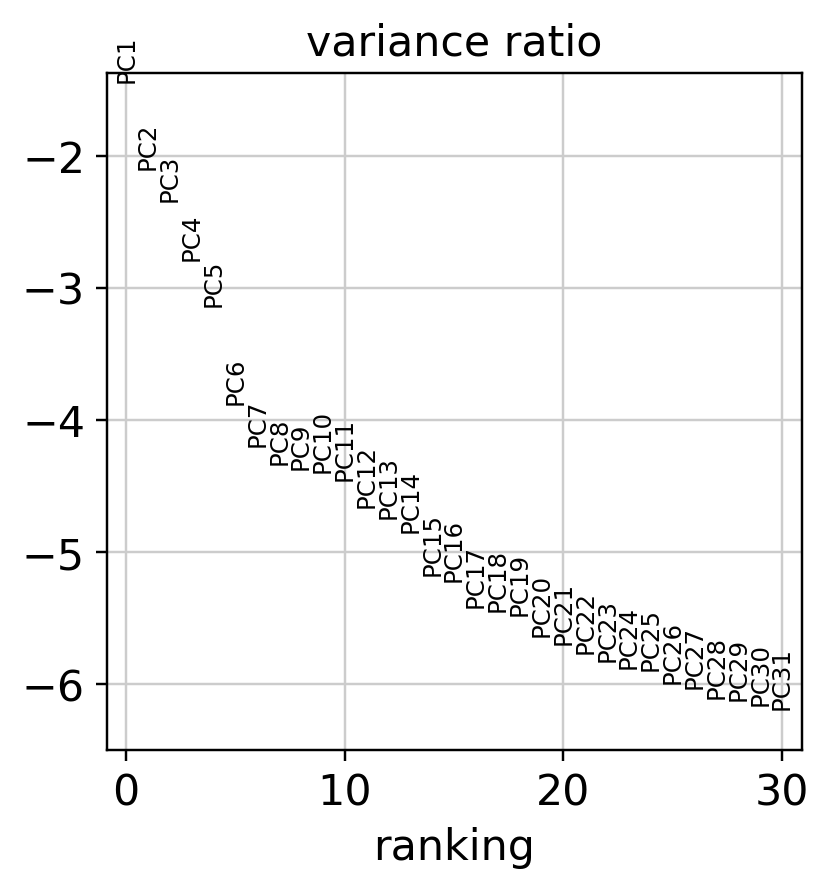

In [ ]:
# PCA
sc.tl.pca(adata, svd_solver="arpack")
sc.pl.pca_variance_ratio(adata, log=True)

## Clustering Analysis

### 1. Cluster variable and overview

In [ ]:
N_NEIGHBORS = 10
N_PCS = 40
UMAP_MIN_DIST = 0.3

sc.pp.neighbors(adata, n_neighbors=N_NEIGHBORS, n_pcs=N_PCS)
sc.tl.umap(adata, min_dist=UMAP_MIN_DIST)





KeyboardInterrupt: 

### 2. Cluster method

In [ ]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score

def run_louvain(adata, resolution=1.0, key='cluster_louvain'):
    sc.tl.louvain(adata, resolution=resolution, key_added=key)
    return key

def run_leiden(adata, resolution=1.0, key='cluster_leiden'):

    sc.tl.leiden(adata, resolution=resolution, key_added=key)
    return key

def run_kmeans_on_pca(adata, n_clusters=None, key='cluster_kmeans'):

    if n_clusters is None:
        if 'cluster_louvain' in adata.obs:
            n_clusters = adata.obs['cluster_louvain'].nunique()
        else:

            n_clusters = 8
    X = adata.obsm['X_pca'][:, :N_PCS] if adata.obsm.get('X_pca') is not None else adata.X
    km = KMeans(n_clusters=n_clusters, n_init=20, random_state=42)
    labels = km.fit_predict(X)
    adata.obs[key] = labels.astype(str)
    return key

def eval_clustering(adata, key):
    X = adata.obsm['X_pca'][:, :N_PCS]
    labels = adata.obs[key].values

    if len(np.unique(labels)) < 2:
        return {'silhouette': np.nan, 'calinski_harabasz': np.nan, 'davies_bouldin': np.nan}
    return {
        'silhouette': silhouette_score(X, labels),
        'calinski_harabasz': calinski_harabasz_score(X, labels),
        'davies_bouldin': davies_bouldin_score(X, labels),
    }

def plot_umap(adata, key, title=None, save=None):
    sc.pl.umap(adata, color=[key], legend_loc='on data', frameon=False, title=title or key, show=False, wspace=0.3)
    if save:
        plt.savefig(save, dpi=300, bbox_inches='tight')
    plt.show()


### 3. run cluster method

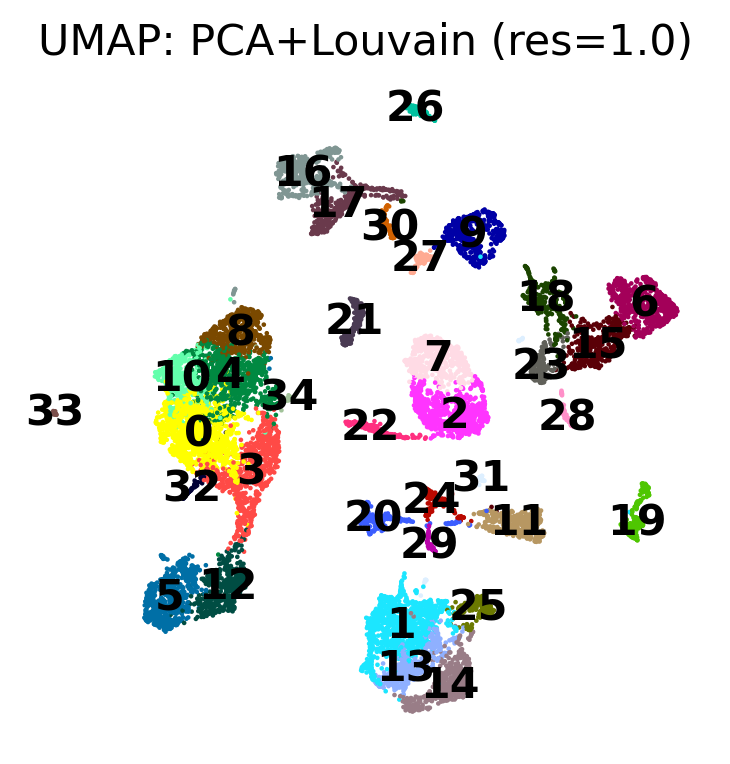

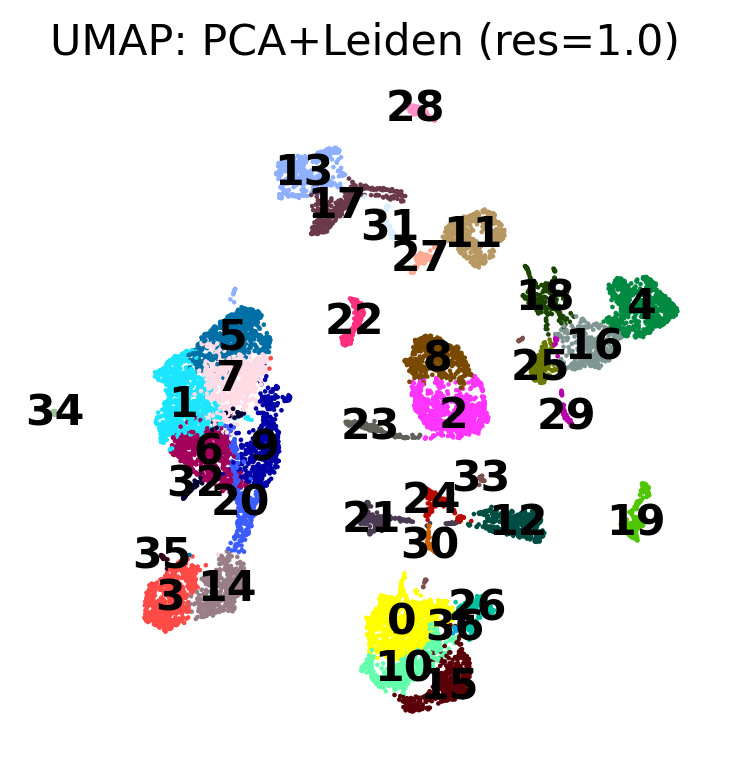

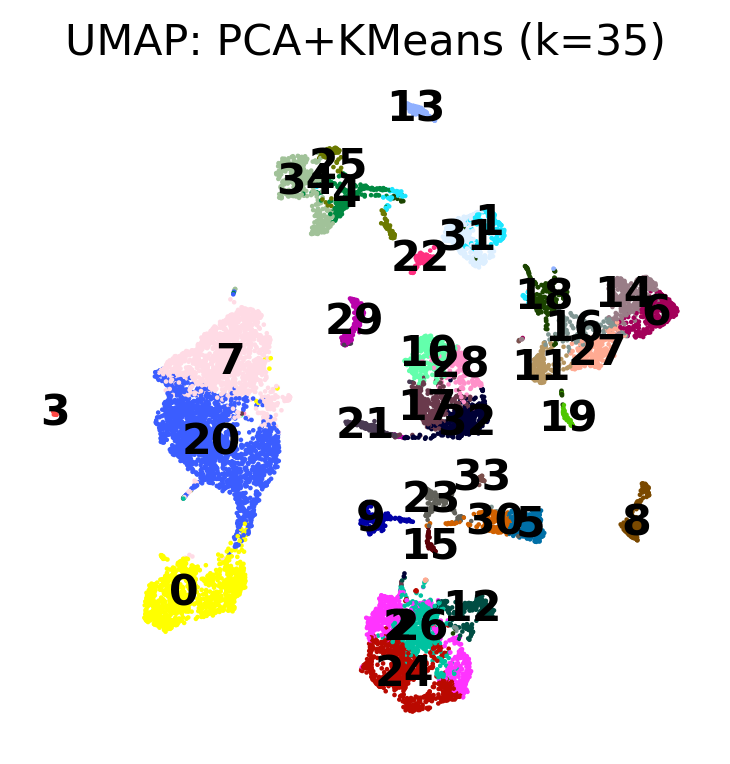

In [ ]:


RES = 1.0
keys = {}


keys['louvain'] = run_louvain(adata, resolution=RES, key='cluster_louvain')


keys['leiden']  = run_leiden(adata,  resolution=RES, key='cluster_leiden')


k_kmeans = adata.obs['cluster_louvain'].nunique()
keys['kmeans']  = run_kmeans_on_pca(adata, n_clusters=k_kmeans, key='cluster_kmeans')


plot_umap(adata, keys['louvain'], title=f'UMAP: PCA+Louvain (res={RES})', save='fig_clustering_louvain.png')
plot_umap(adata, keys['leiden'],  title=f'UMAP: PCA+Leiden (res={RES})',  save='fig_clustering_leiden.png')
plot_umap(adata, keys['kmeans'],  title=f'UMAP: PCA+KMeans (k={k_kmeans})', save='fig_clustering_kmeans.png')


### 4. Adjusted Rand Index analysis

,method,n_clusters,silhouette,calinski_harabasz,davies_bouldin
2,kmeans,35,0.292305,3717.959297,1.307096
1,leiden,37,0.248700,3065.718488,1.253271
0,louvain,35,0.243609,3166.395874,1.302422


,pair,ARI
0,louvain vs leiden,0.785458
1,louvain vs kmeans,0.518473
2,leiden vs kmeans,0.473399


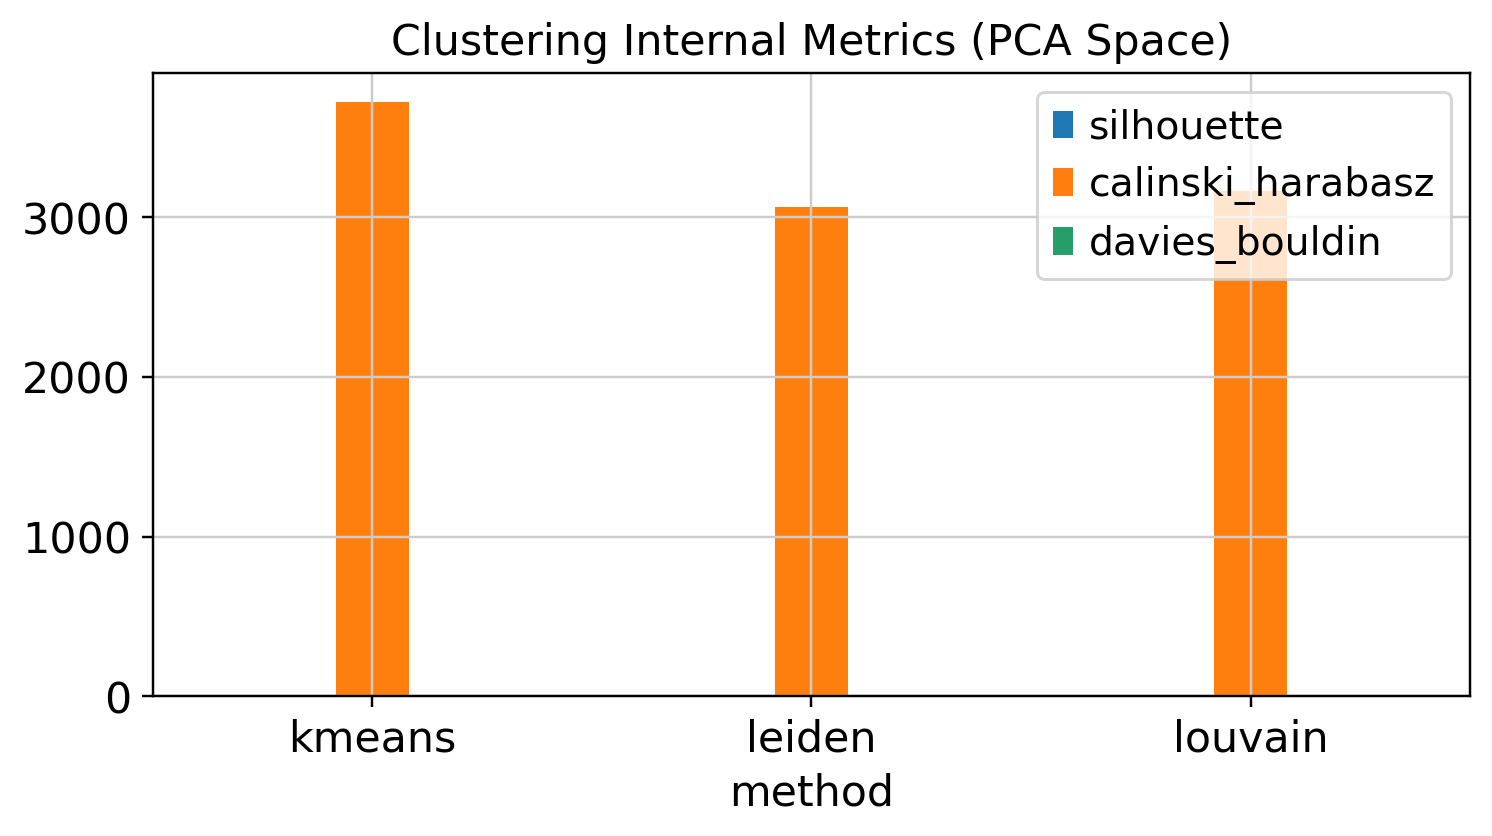

In [ ]:

rows = []
for m, key in keys.items():
    scores = eval_clustering(adata, key)
    rows.append({'method': m,
                 'n_clusters': adata.obs[key].nunique(),
                 **scores})
metrics_df = pd.DataFrame(rows).sort_values('method')
display(metrics_df)


pairs = [
    ('louvain', 'leiden'),
    ('louvain', 'kmeans'),
    ('leiden',  'kmeans'),
]
ari_rows = []
for a, b in pairs:
    la = adata.obs[keys[a]].values
    lb = adata.obs[keys[b]].values
    ari_rows.append({'pair': f'{a} vs {b}', 'ARI': adjusted_rand_score(la, lb)})
ari_df = pd.DataFrame(ari_rows)
display(ari_df)


metrics_df.to_csv('clustering_internal_metrics.csv', index=False)
ari_df.to_csv('clustering_method_ARI.csv', index=False)


ax = metrics_df.set_index('method')[['silhouette','calinski_harabasz','davies_bouldin']].plot(kind='bar', figsize=(7,4))
plt.xticks(rotation=0)
plt.title('Clustering Internal Metrics (PCA Space)')
plt.tight_layout()
plt.savefig('fig_metrics_bar.png', dpi=300)
plt.show()


### 5. genes marker compare

Saved: markers_cluster_louvain.csv


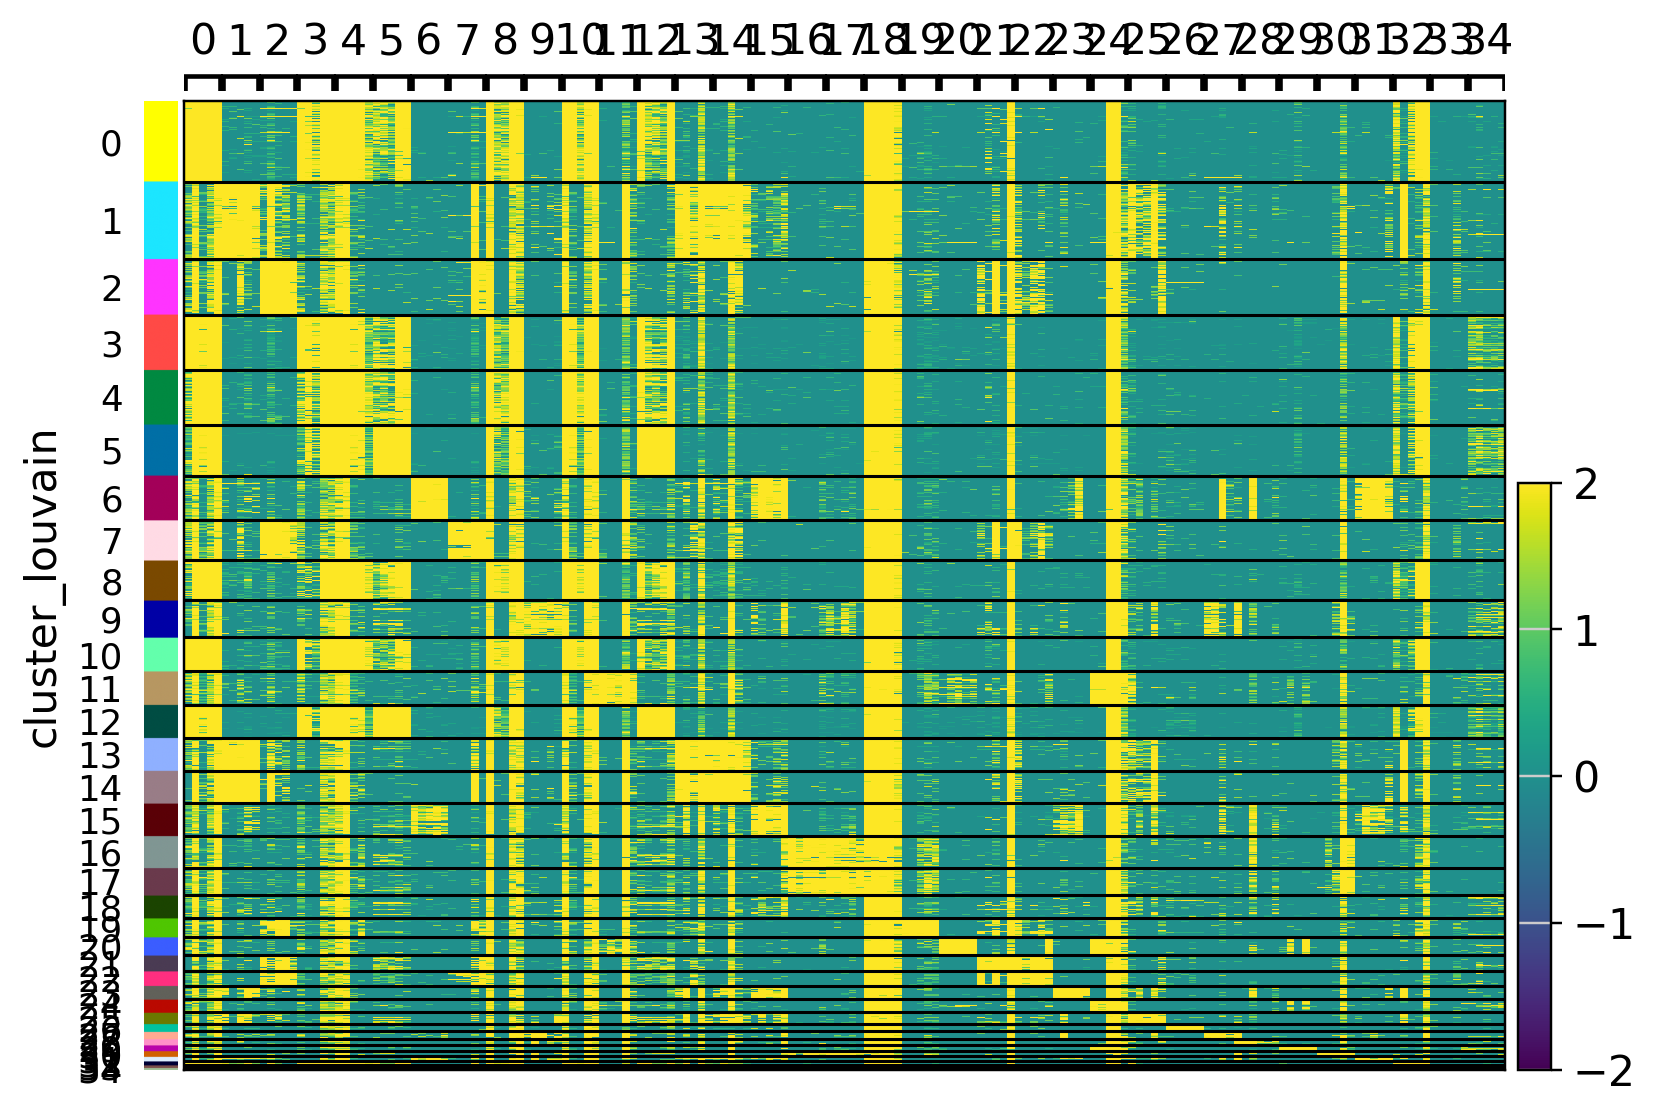

Saved: markers_cluster_leiden.csv


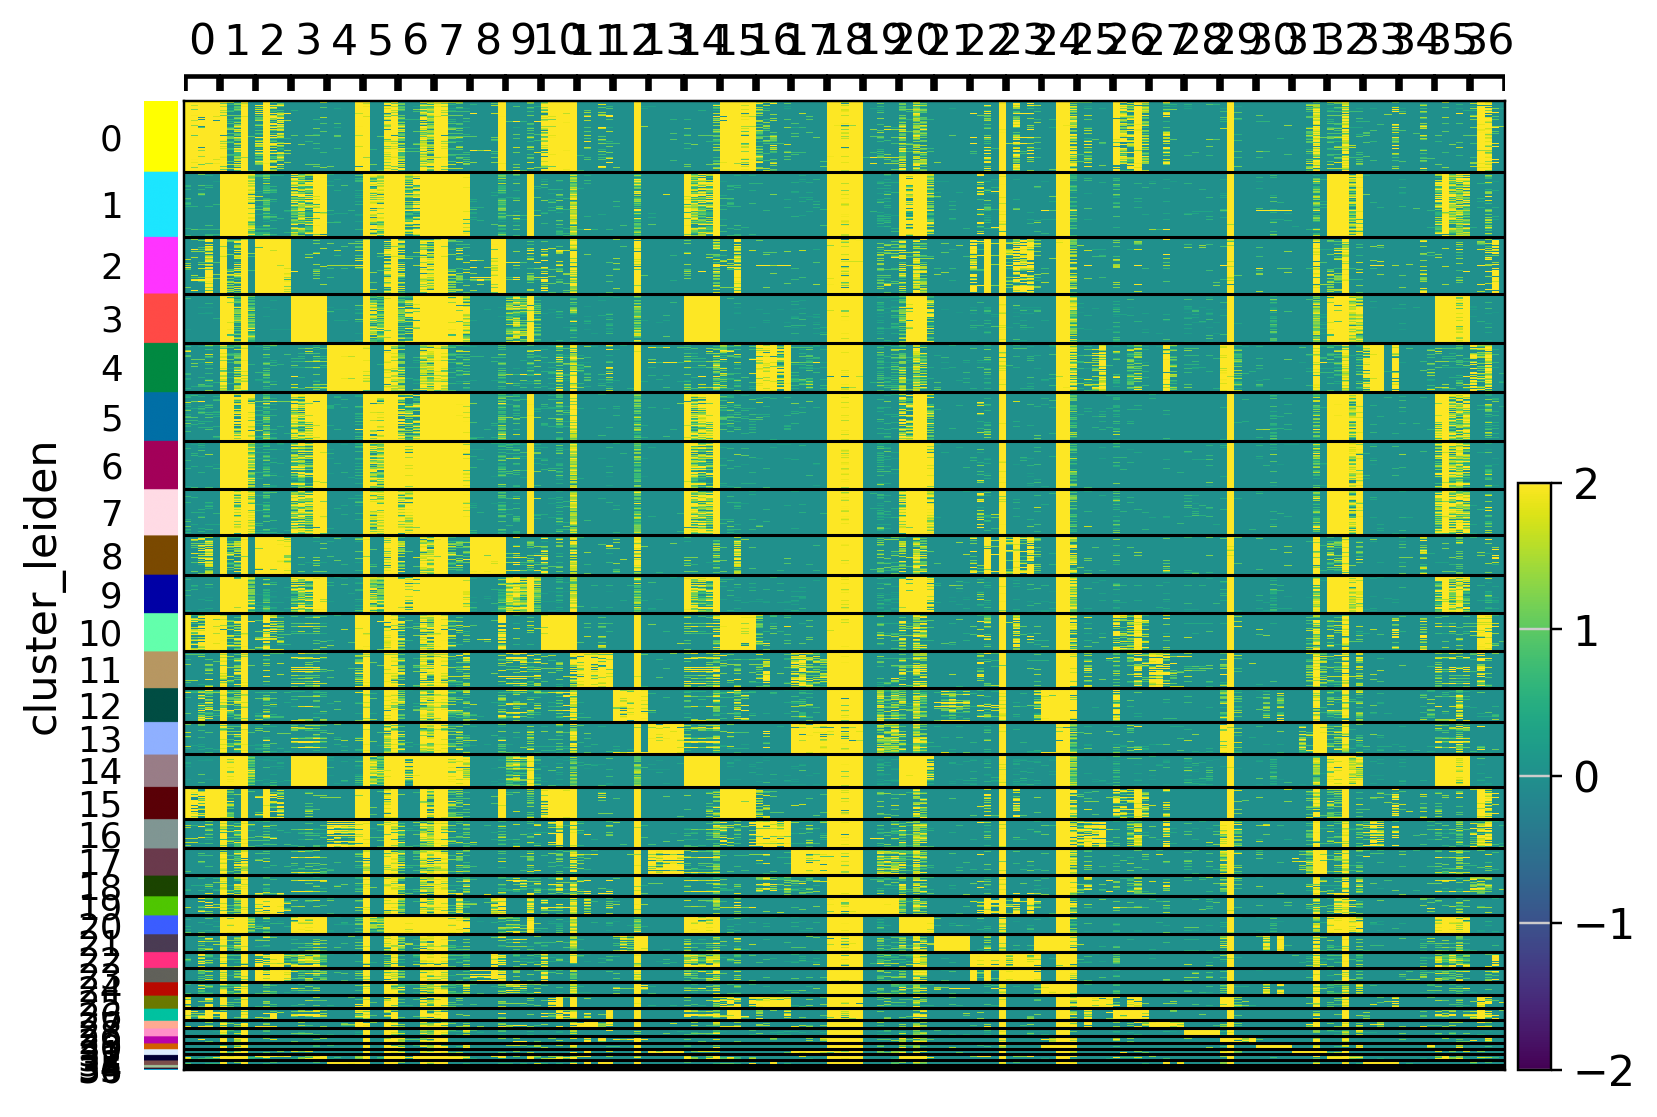

Saved: markers_cluster_kmeans.csv


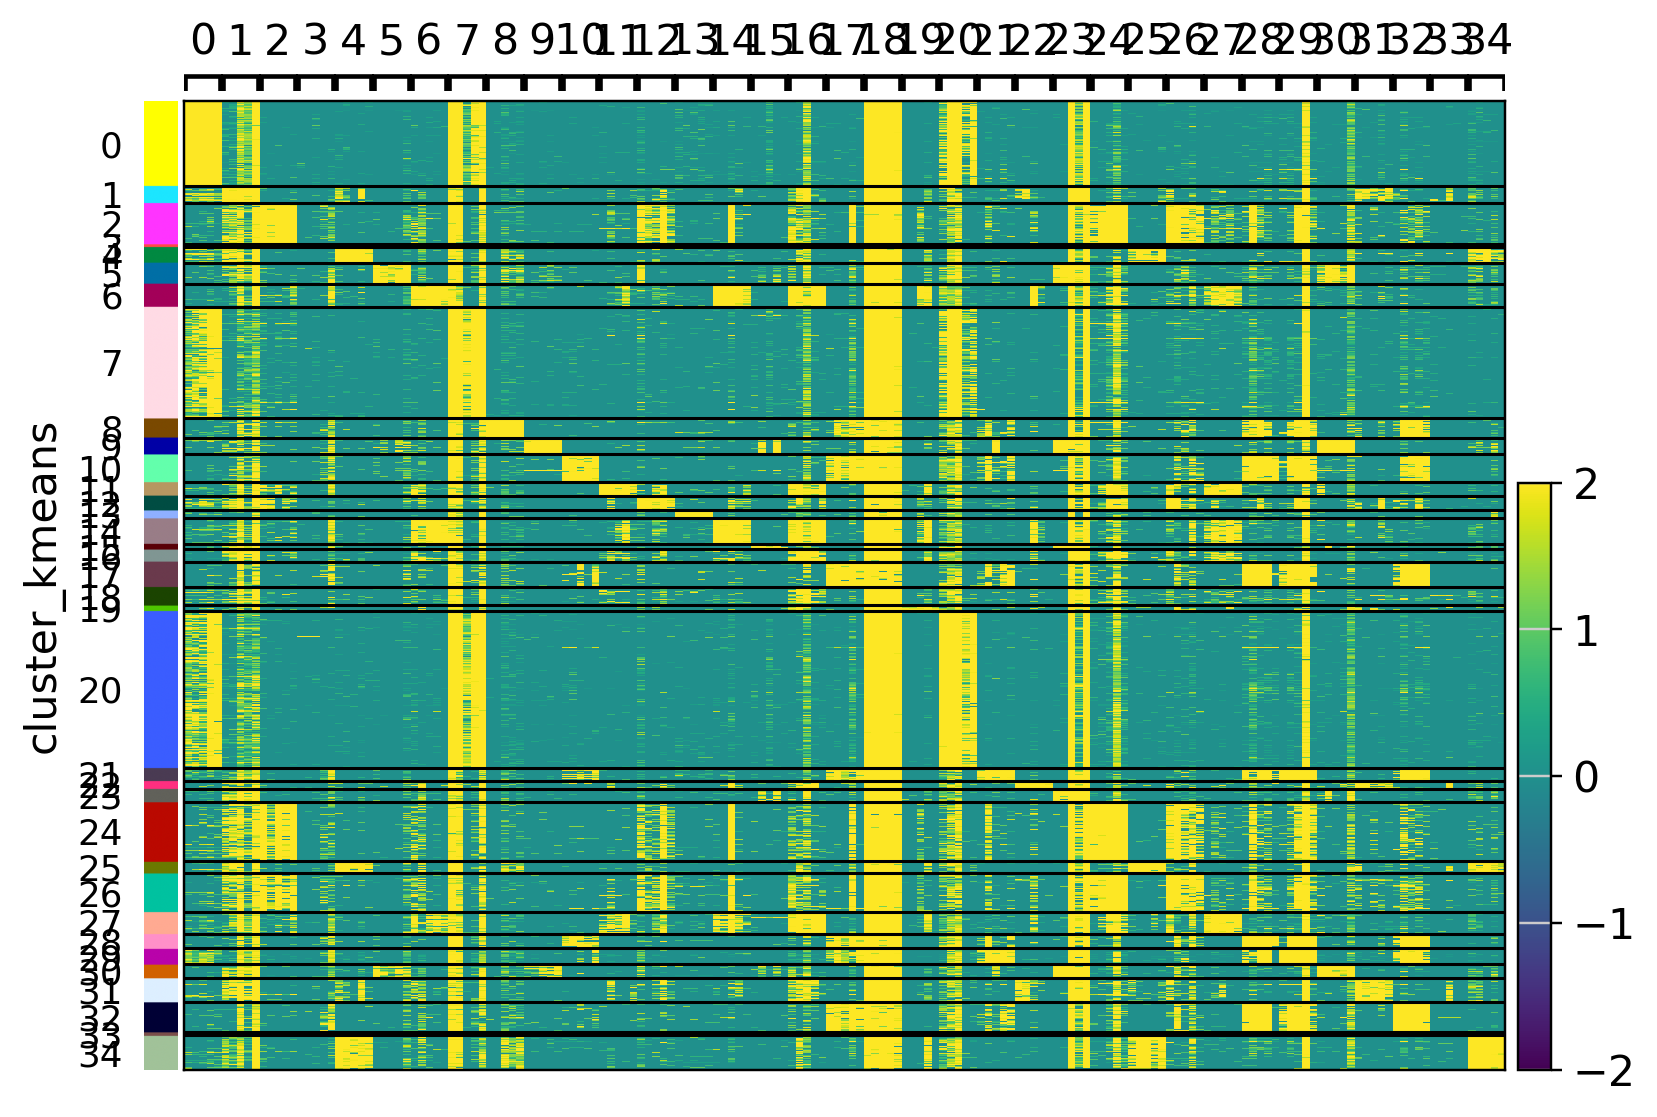

In [ ]:
def rank_markers_for(adata, key, n_top=50, out_prefix='markers'):
    sc.tl.rank_genes_groups(adata, groupby=key, method='wilcoxon', n_genes=n_top)
    tbl = sc.get.rank_genes_groups_df(adata, group=None)
    csv_path = f'{out_prefix}_{key}.csv'
    tbl.to_csv(csv_path, index=False)
    print(f'Saved: {csv_path}')
    sc.pl.rank_genes_groups_heatmap(adata, groupby=key, n_genes=5, show=False, dendrogram=False, vmin=-2, vmax=2)
    plt.savefig(f'fig_markers_heatmap_{key}.png', dpi=300, bbox_inches='tight')
    plt.show()

for m, key in keys.items():
    rank_markers_for(adata, key, n_top=100, out_prefix='markers')
